Imports

In [1]:
# from google.colab import drive
# drive.mount('/content/drive/')

# # path = "drive/MyDrive/645-project-data/" # Google Drive path
path = "data/"  # Local path

In [2]:
# Check GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)

if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

# Check RAM
from psutil import virtual_memory

ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Mon Apr  4 03:12:32 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
from IPython.display import display, Image
import os
import pathlib
import glob
import shutil
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot

Loading the Data

In [4]:
!mkdir data

In [ ]:
!ls

data  sample_data


In [5]:
%%capture
!unzip train.zip -d data/train

In [ ]:
# Upload train.zip to local colab storage before running this cell
# !mkdir data
!unzip train.zip -d data/train

# COMMENT OUT THIS CELL AFTER RUNNING ONCE

Archive:  train.zip
replace data/train/000bec180eb18c7604dcecc8fe0dba07.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
labels = pd.read_csv(path + "labels.csv")
labels["id"] = [fname + ".jpg" for fname in labels["id"]]
print(f"There are a total of {labels.describe().iloc[1, :][0]} labeled images")
print(f"There are {labels.describe().iloc[1, :][1]} different dog breeds in this dataset")

There are a total of 10222 labeled images
There are 120 different dog breeds in this dataset


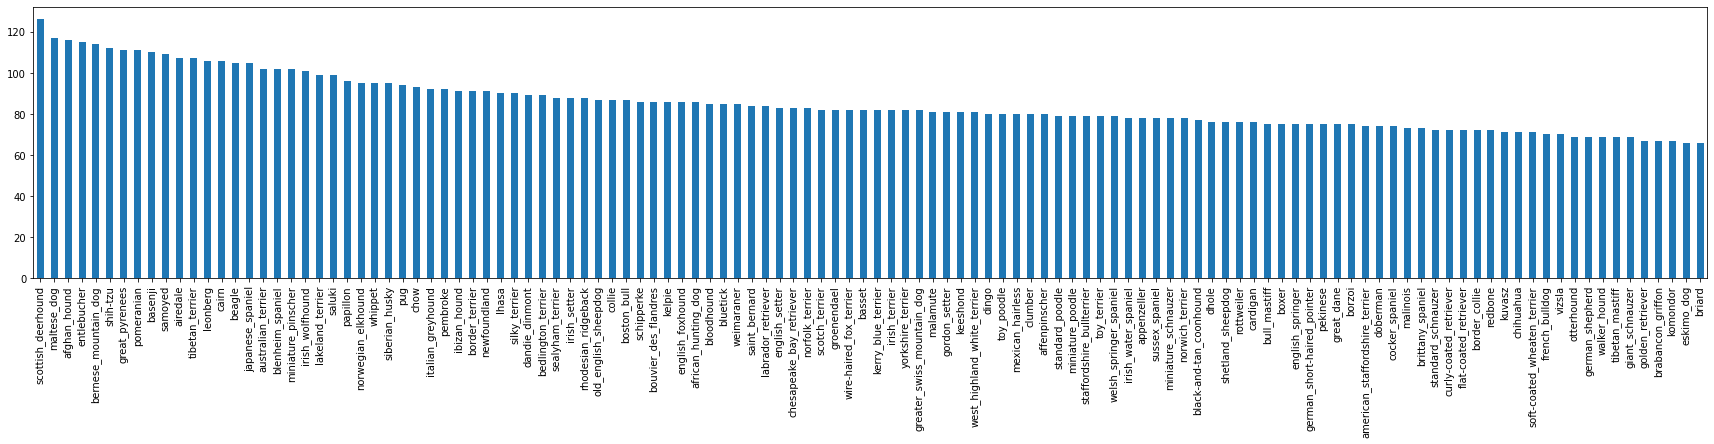

In [ ]:
labels["breed"].value_counts().plot.bar(figsize=(30, 5))
plt.show()

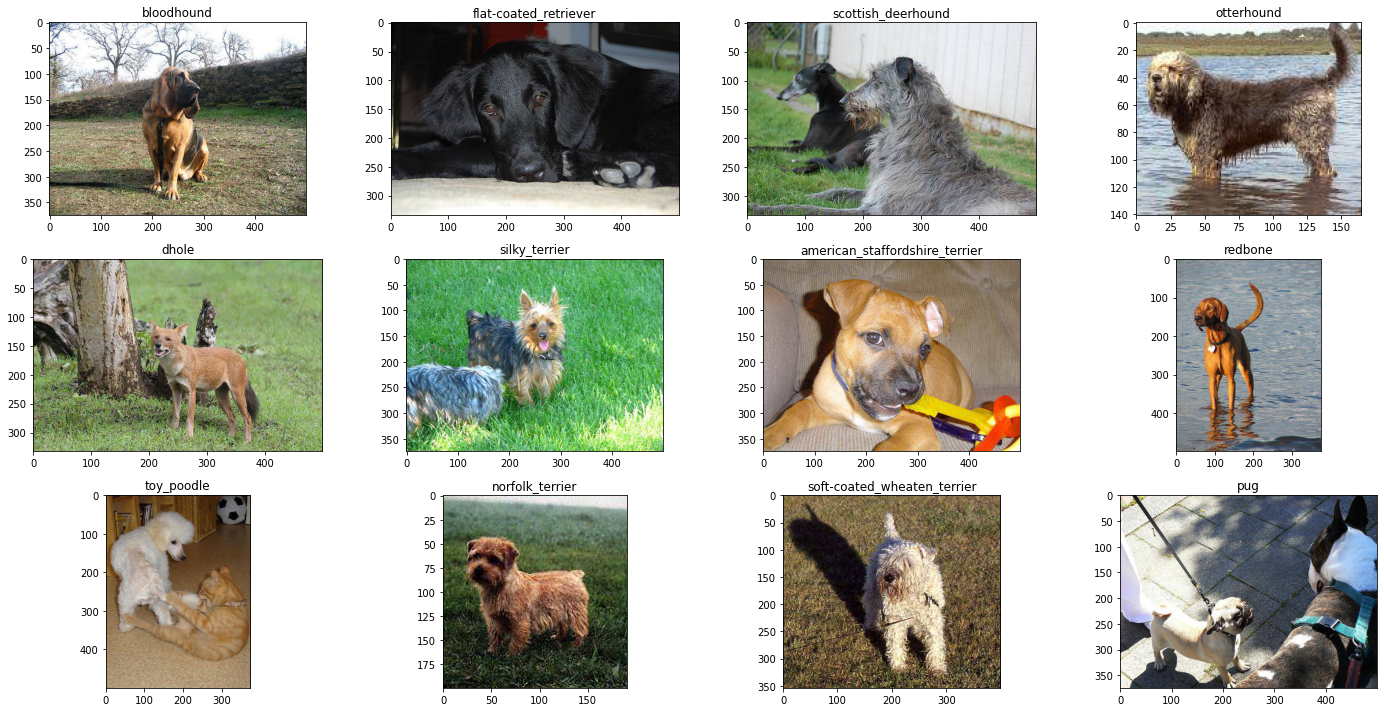

In [ ]:
sample_imgs = []
for index, row in labels.sample(12).iterrows():
    sample_imgs.append((row["id"], row["breed"]))

fig = plt.figure(figsize=(20, 10))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    img = mpimg.imread(path + "train/" + sample_imgs[i-1][0])
    # img = mpimg.imread(path + "/" + sample_imgs[i-1][0])
    fig.add_subplot(rows, columns, i).title.set_text(sample_imgs[i-1][1])
    plt.imshow(img)
plt.tight_layout()
plt.show()

Data Augmentation & Preprocessing

In [ ]:
BATCH_SIZE = 64
IMG_SIZE = 224

# Train and validation generators

# Ensures the data is preprocessed exactly how the data in the pretrained model was
datagen = ImageDataGenerator(preprocessing_function = tf.keras.applications.vgg16.preprocess_input, validation_split=0.25)

train_generator = datagen.flow_from_dataframe(
                        dataframe = labels,
                        directory = path + "train/",
                        x_col="id",
                        y_col="breed",
                        subset="training",
                        batch_size=BATCH_SIZE,
                        seed=42,
                        shuffle=True,
                        class_mode="sparse",
                        color_mode="rgb",
                        target_size=(IMG_SIZE, IMG_SIZE))

validation_generator = datagen.flow_from_dataframe(
                        dataframe = labels,
                        directory = path + "train/",
                        x_col="id",
                        y_col="breed",
                        subset="validation",
                        batch_size=BATCH_SIZE,
                        seed=42,
                        shuffle=True, 
                        class_mode="sparse",
                        color_mode="rgb",
                        target_size=(IMG_SIZE, IMG_SIZE))

Found 7667 validated image filenames belonging to 120 classes.
Found 2555 validated image filenames belonging to 120 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

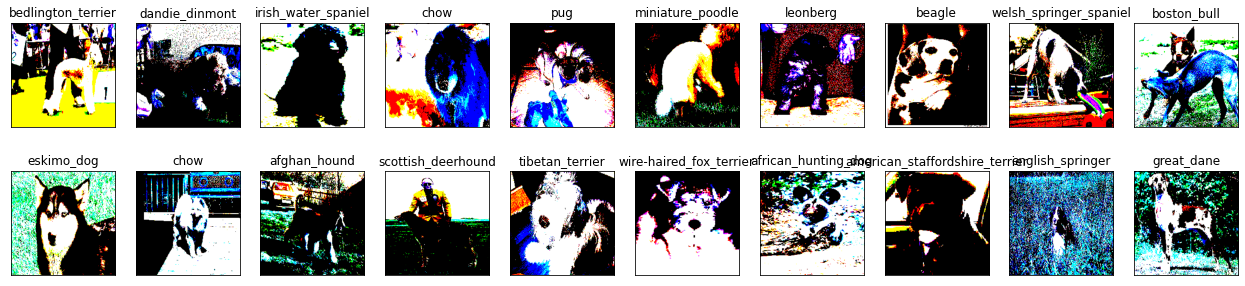

In [ ]:
class_names = [name for name in train_generator.class_indices.keys()]
images, labels = next(iter(train_generator))

fig = plt.figure(figsize=(22, 5))

for i in np.arange(20):
    ax = fig.add_subplot(2, 10, i + 1, xticks=[], yticks=[])
    plt.imshow(images[i])
    ax.set_title(class_names[int(labels[i])])

Modelling

In [ ]:
# Using the keras Sequential API (another way of doing it would be the Functional API)

# Overall model
vgg16_model = tf.keras.Sequential()

# Retrieve the pre-trained model
pretrained_model = tf.keras.applications.VGG16(include_top=False,
                   input_shape=(IMG_SIZE, IMG_SIZE, 3),
                   weights='imagenet')

# Freeze all the layers in the pretrained model
for layer in pretrained_model.layers:
    layer.trainable=False


# Modify the 'top layer' parameters         
vgg16_model.add(pretrained_model) # Add the pre-trained model to the model
vgg16_model.add(tf.keras.layers.Flatten())
vgg16_model.add(tf.keras.layers.Dense(len(class_names), activation='softmax'))
vgg16_model.summary()

58900480/58889256 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 120)               3010680   
                                                                 
Total params: 17,725,368
Trainable params: 3,010,680
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
# Names for model to be saved
model_name_it = "dog_breed_classifier_vgg16.h5"
model_name_ft = "dog_breed_classifier_vgg16.h5"

# Early stopping for when scores plateau
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# Checkpoints to save model periodically
monitor_it = tf.keras.callbacks.ModelCheckpoint(model_name_it, monitor='val_loss',
                                                verbose=0,save_best_only=True,
                                                save_weights_only=False,
                                                mode='min')

monitor_ft = tf.keras.callbacks.ModelCheckpoint(model_name_ft, monitor='val_loss',
                                                verbose=0,save_best_only=True,
                                                save_weights_only=False,
                                                mode='min')

# Learning rate decay scheduler
def scheduler(epoch, lr):
    if epoch % 10 == 0 and epoch != 0:
        lr = lr / 2

    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=0)

In [ ]:
 # Optimizer to be used - other options are Adam and SGD
optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-3, rho=0.9)

# Compile 
vgg16_model.compile(optimizer=optimizer,
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])

history_it = vgg16_model.fit(train_generator, epochs=20, verbose = 1, 
                             callbacks=[early_stop, monitor_it, lr_schedule], 
                             validation_data=(validation_generator))

Epoch 1/20
120/120 [==============================] - 52s 357ms/step - loss: 63.4476 - accuracy: 0.2916 - val_loss: 44.8315 - val_accuracy: 0.3980 - lr: 0.0010
Epoch 2/20
120/120 [==============================] - 40s 336ms/step - loss: 8.9033 - accuracy: 0.8126 - val_loss: 46.2632 - val_accuracy: 0.4184 - lr: 0.0010
Epoch 3/20
120/120 [==============================] - 40s 334ms/step - loss: 4.4758 - accuracy: 0.8947 - val_loss: 45.1845 - val_accuracy: 0.4583 - lr: 0.0010
Epoch 4/20
120/120 [==============================] - 41s 338ms/step - loss: 3.0908 - accuracy: 0.9284 - val_loss: 45.7497 - val_accuracy: 0.4626 - lr: 0.0010
Epoch 5/20
120/120 [==============================] - 41s 338ms/step - loss: 1.8858 - accuracy: 0.9562 - val_loss: 51.3223 - val_accuracy: 0.4481 - lr: 0.0010
Epoch 6/20
120/120 [==============================] - 40s 333ms/step - loss: 1.4601 - accuracy: 0.9643 - val_loss: 47.1206 - val_accuracy: 0.4751 - lr: 0.0010
Epoch 7/20
120/120 [=========================

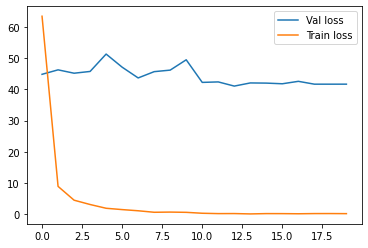

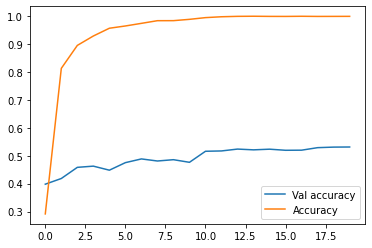

In [ ]:
plt.figure()
plt.plot(history_it.history["val_loss"], label = "Val loss")
plt.plot(history_it.history["loss"], label = "Train loss")
plt.legend()
plt.show()

plt.figure()
plt.plot(history_it.history["val_accuracy"], label = "Val accuracy")
plt.plot(history_it.history["accuracy"], label = "Accuracy")
plt.legend()

In [ ]:
from keras.models import load_model

model = load_model('./dog_breed_classifier_vgg16.h5')

model.get_layer('vgg16').trainable = True

#Review the layer names 
for layer in model.get_layer('vgg16').layers:
  print(layer.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool


In [ ]:
#Fine tune, the layers by unfreezing the conv3 layers.
for layer in model.get_layer('vgg16').layers:
  if "conv3" in layer.name:
    pass
  else:
    layer.trainable = False

In [ ]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-3, rho=0.9)

# Re-compiling the model
model.compile(optimizer=optimizer,
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 120)               3010680   
                                                                 
Total params: 17,725,368
Trainable params: 8,320,376
Non-trainable params: 9,404,992
_________________________________________________________________


In [ ]:
# Training the model with the pre-trained weights unfrozen

model_name_it = "dog_breed_classifier_vgg16_unfrozen.h5"
model_name_ft = "dog_breed_classifier_vgg16_unfrozen.h5"

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)


monitor_it = tf.keras.callbacks.ModelCheckpoint(model_name_it, monitor='val_loss',
                                                verbose=0,save_best_only=True,
                                                save_weights_only=False,
                                                mode='min')

monitor_ft = tf.keras.callbacks.ModelCheckpoint(model_name_ft, monitor='val_loss',
                                                verbose=0,save_best_only=True,
                                                save_weights_only=False,
                                                mode='min')

def scheduler(epoch, lr):
    if epoch % 5 == 0 and epoch!= 0:
        lr = lr/2

    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=0)

history_it = model.fit(train_generator, epochs=20, verbose = 1,
                              callbacks= [early_stop, monitor_it, lr_schedule],
                              validation_data = (validation_generator))

Epoch 1/20
120/120 [==============================] - 42s 339ms/step - loss: 116.4828 - accuracy: 0.0836 - val_loss: 4.7877 - val_accuracy: 0.0090 - lr: 0.0010
Epoch 2/20
120/120 [==============================] - 40s 335ms/step - loss: 5.2748 - accuracy: 0.0098 - val_loss: 4.7864 - val_accuracy: 0.0086 - lr: 0.0010
Epoch 3/20
120/120 [==============================] - 40s 330ms/step - loss: 4.7845 - accuracy: 0.0115 - val_loss: 4.7858 - val_accuracy: 0.0086 - lr: 0.0010
Epoch 4/20
120/120 [==============================] - 40s 330ms/step - loss: 4.7828 - accuracy: 0.0120 - val_loss: 4.7854 - val_accuracy: 0.0110 - lr: 0.0010
Epoch 5/20
120/120 [==============================] - 40s 331ms/step - loss: 4.7815 - accuracy: 0.0128 - val_loss: 4.7851 - val_accuracy: 0.0110 - lr: 0.0010
Epoch 6/20
120/120 [==============================] - 40s 333ms/step - loss: 4.7803 - accuracy: 0.0128 - val_loss: 4.7850 - val_accuracy: 0.0110 - lr: 5.0000e-04
Epoch 7/20
120/120 [==========================